<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=150px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Causal Inference In Statistics - A Primer</h1>
        <h1>2.5 Model Testing and Causal Search</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
    <div style="float: right; margin-right:10px;"> <p><a href="https://amzn.to/3gsFlkO" target=_blank><img src='data/causality.jpeg' width='100px'>
        <!--Amazon Affiliate Link--></a></p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

import statsmodels.formula.api as smf

from CausalModel import CausalModel

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.13.2
IPython version      : 9.2.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit

Git hash: f7b1abb57541776dc786174deb102ca4ab864df6

statsmodels: 0.14.4
matplotlib : 3.10.0
numpy      : 2.2.4
pandas     : 2.2.3
watermark  : 2.5.0



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Model Testing and Causal Search

In [4]:
G = CausalModel()
G.add_causation('X1', 'X2')
G.add_causation('X1', 'X3')
G.add_causation('X3', 'X4')
G.add_causation('X2', 'X4')
G.add_causation('X4', 'X5')

G.pos = {'X1':(0, 2), 'X3':(-1, 1), 'X2': (1, 1), 'X4':(0, 0), 'X5':(0, -1)}

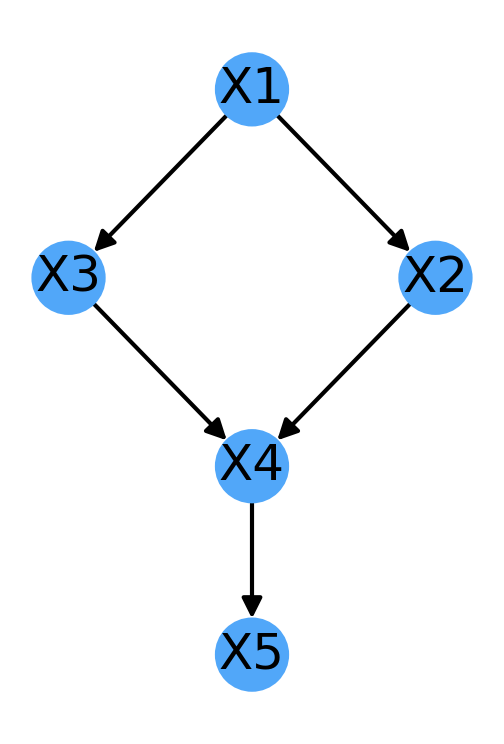

In [5]:
fig, ax = plt.subplots(1, figsize=(2.2, 3))
G.plot()
fig.tight_layout()

In [6]:
G.save_model('dags/Causality.Fig.1.2.dot')

This model has just one v_structure, namely the collider at X4

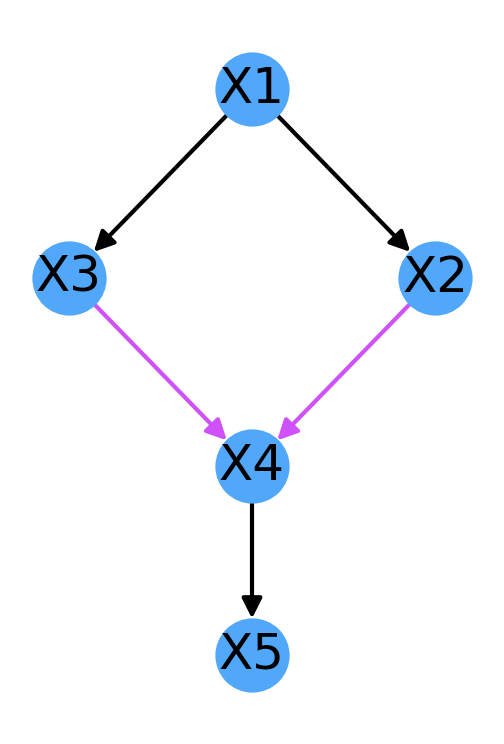

In [7]:
fig, ax_lst = plt.subplots(1, figsize=(2.2, 3))
ax_lst = np.array(ax_lst).flatten()

structs = G.v_structures()

for i, path in enumerate(structs):
    G.plot_path(path, ax=ax_lst[i], edges=True, lw=1)

ax_lst[-1].axis('off')
fig.tight_layout()

But it has 3 models in it's equivalence class

In [8]:
equivalent = G.equivalence_class()

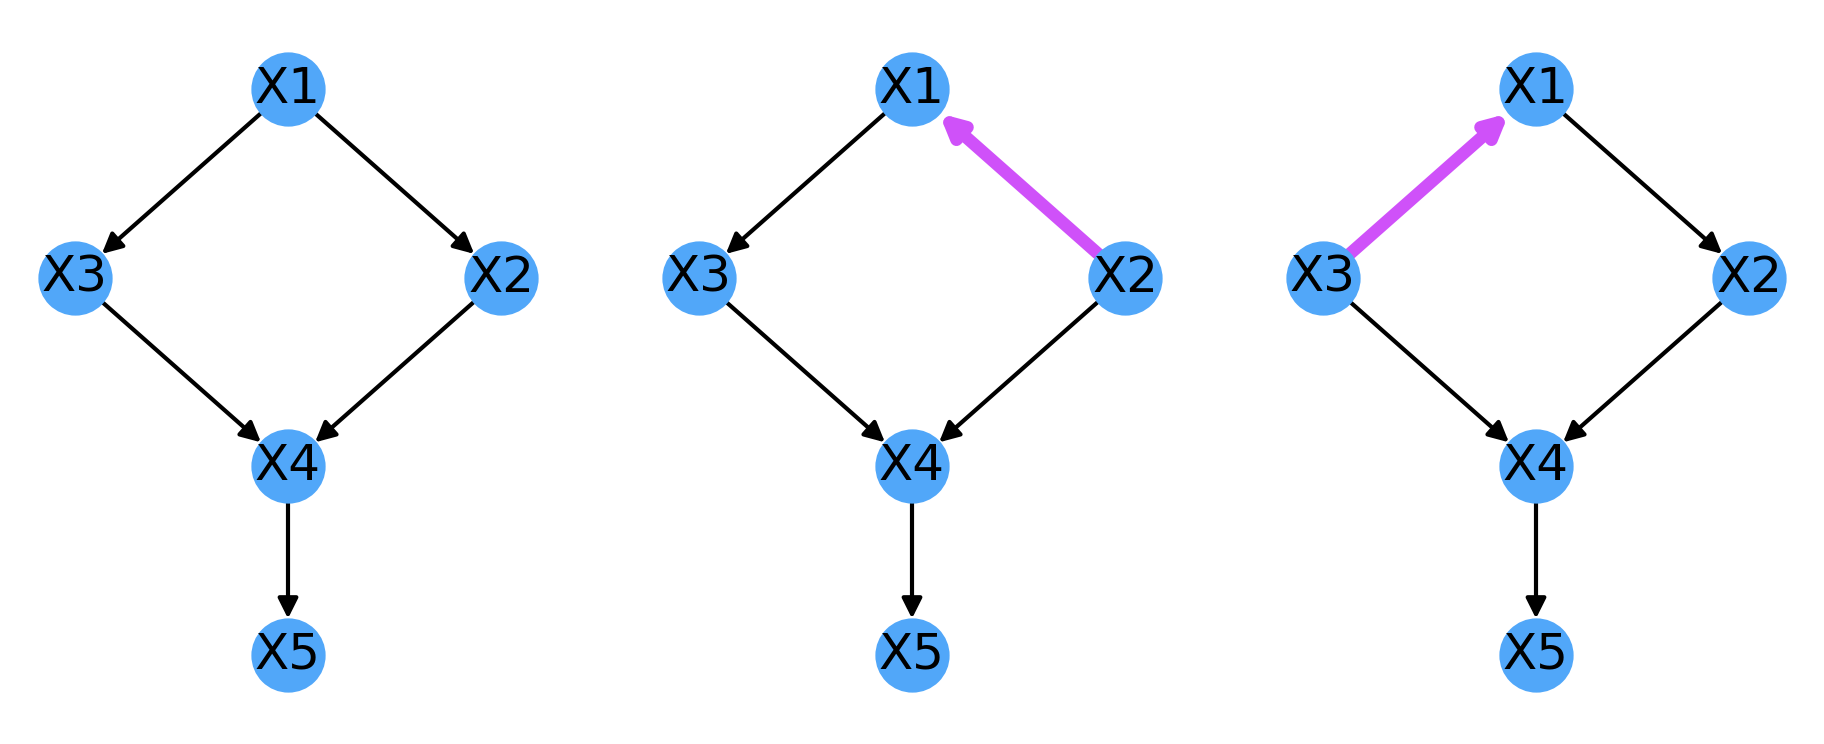

In [9]:
fig, ax_lst = plt.subplots(1, 3, figsize=(6.6, 3))
ax_lst = np.array(ax_lst).flatten()

pos = 0

for graph, edge in equivalent:
    graph.plot_path(edge, ax=ax_lst[pos])
    pos += 1

fig.tight_layout()

One way to verify that these 3 graphs are equivalent is to check their basis set:

In [10]:
for graph, edges in equivalent:
    pprint(graph.basis_set())
    print()

['X2 _||_ X3 | X1',
 'X3 _||_ X2 | X1',
 'X4 _||_ X1 | X2, X3',
 'X5 _||_ X1, X2, X3 | X4']

['X3 _||_ X2 | X1', 'X4 _||_ X1 | X2, X3', 'X5 _||_ X1, X2, X3 | X4']

['X2 _||_ X3 | X1', 'X4 _||_ X1 | X2, X3', 'X5 _||_ X1, X2, X3 | X4']



As we can see, they are exactly the same if we recall that "X3 _||_ X2 | X1" is equivalent to 'X2 _||_ X3 | X1 '

Now we simulate this model to check these equations:

In [11]:
N = 100000
df = pd.DataFrame({'X1': np.random.normal(0, 1, N)})
df['X2'] = df['X1'] + np.random.normal(0, .1, N)
df['X3'] = df['X1'] + np.random.normal(0, .1, N)
df['X4'] = np.sqrt(0.5)*df['X3'] + np.sqrt(0.5)*df['X2'] + np.random.normal(0, .1, N)
df['X5'] = df['X4'] + np.random.normal(0, .1, N)

We will focus on the X5 equation above:

In [12]:
formula = 'X5 ~ 1 + X3 + X1 + X2 + X4'

Which we can fit

In [13]:
model = smf.ols(formula, df)
results = model.fit()

In [14]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     X5   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 5.054e+06
Date:                Sat, 26 Apr 2025   Prob (F-statistic):               0.00
Time:                        14:03:49   Log-Likelihood:                 88262.
No. Observations:              100000   AIC:                        -1.765e+05
Df Residuals:                   99995   BIC:                        -1.765e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0005      0.000     -1.511      0.131      -0.001       0.000
X3            -0.0028      0.004     -0.728      0.466      -0.010       0.005
X1            -0.0010      0.004     -0.215      0.829      -0.010       0.008
X2            -0.0035      0.004     -0.895      0.371      -0.011       0.004
X4             1.0052      0.003    317.327      0.000       0.999       1.011
==============================================================================
Omnibus:                        0.248   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.883   Jarque-Bera (JB):                0.239
Skew:                          -0.000   Prob(JB):                        0.887
Kurtosis:                       3.008   Cond. No.                         42.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

And verify that the coefficients for X1, X2 and X3 are effectively zero, as expected

In [15]:
def plot_coefficients(results):
    
    summary = results.conf_int().copy()
    summary = pd.concat([summary, results.params], axis=1)
    summary.columns = ['min', 'max', 'value']
    
    independent = results.model.endog_names
    
    fig, ax = plt.subplots(1)
    ax.axvline(x=0, c='darkgray', linestyle=':', linewidth=2)
    ax.hlines(y=np.arange(summary.shape[0]), xmin=summary['min'], xmax=summary['max'], lw=2, color=colors[1])
    ax.vlines(ymin=np.arange(summary.shape[0])-.2, ymax=np.arange(summary.shape[0])+.2, x=summary['value'], lw=2, color=colors[1])
    ax.set_yticks(np.arange(summary.shape[0]))
    ax.set_yticklabels([r'$r_{%s,%s}$' % (independent, node_j) for node_j in summary.index])
    ax.set_xlabel('Coeffient estimate')
    ax.set_ylabel('Variable Pair Coefficient')
    ax.grid(linewidth=.5)

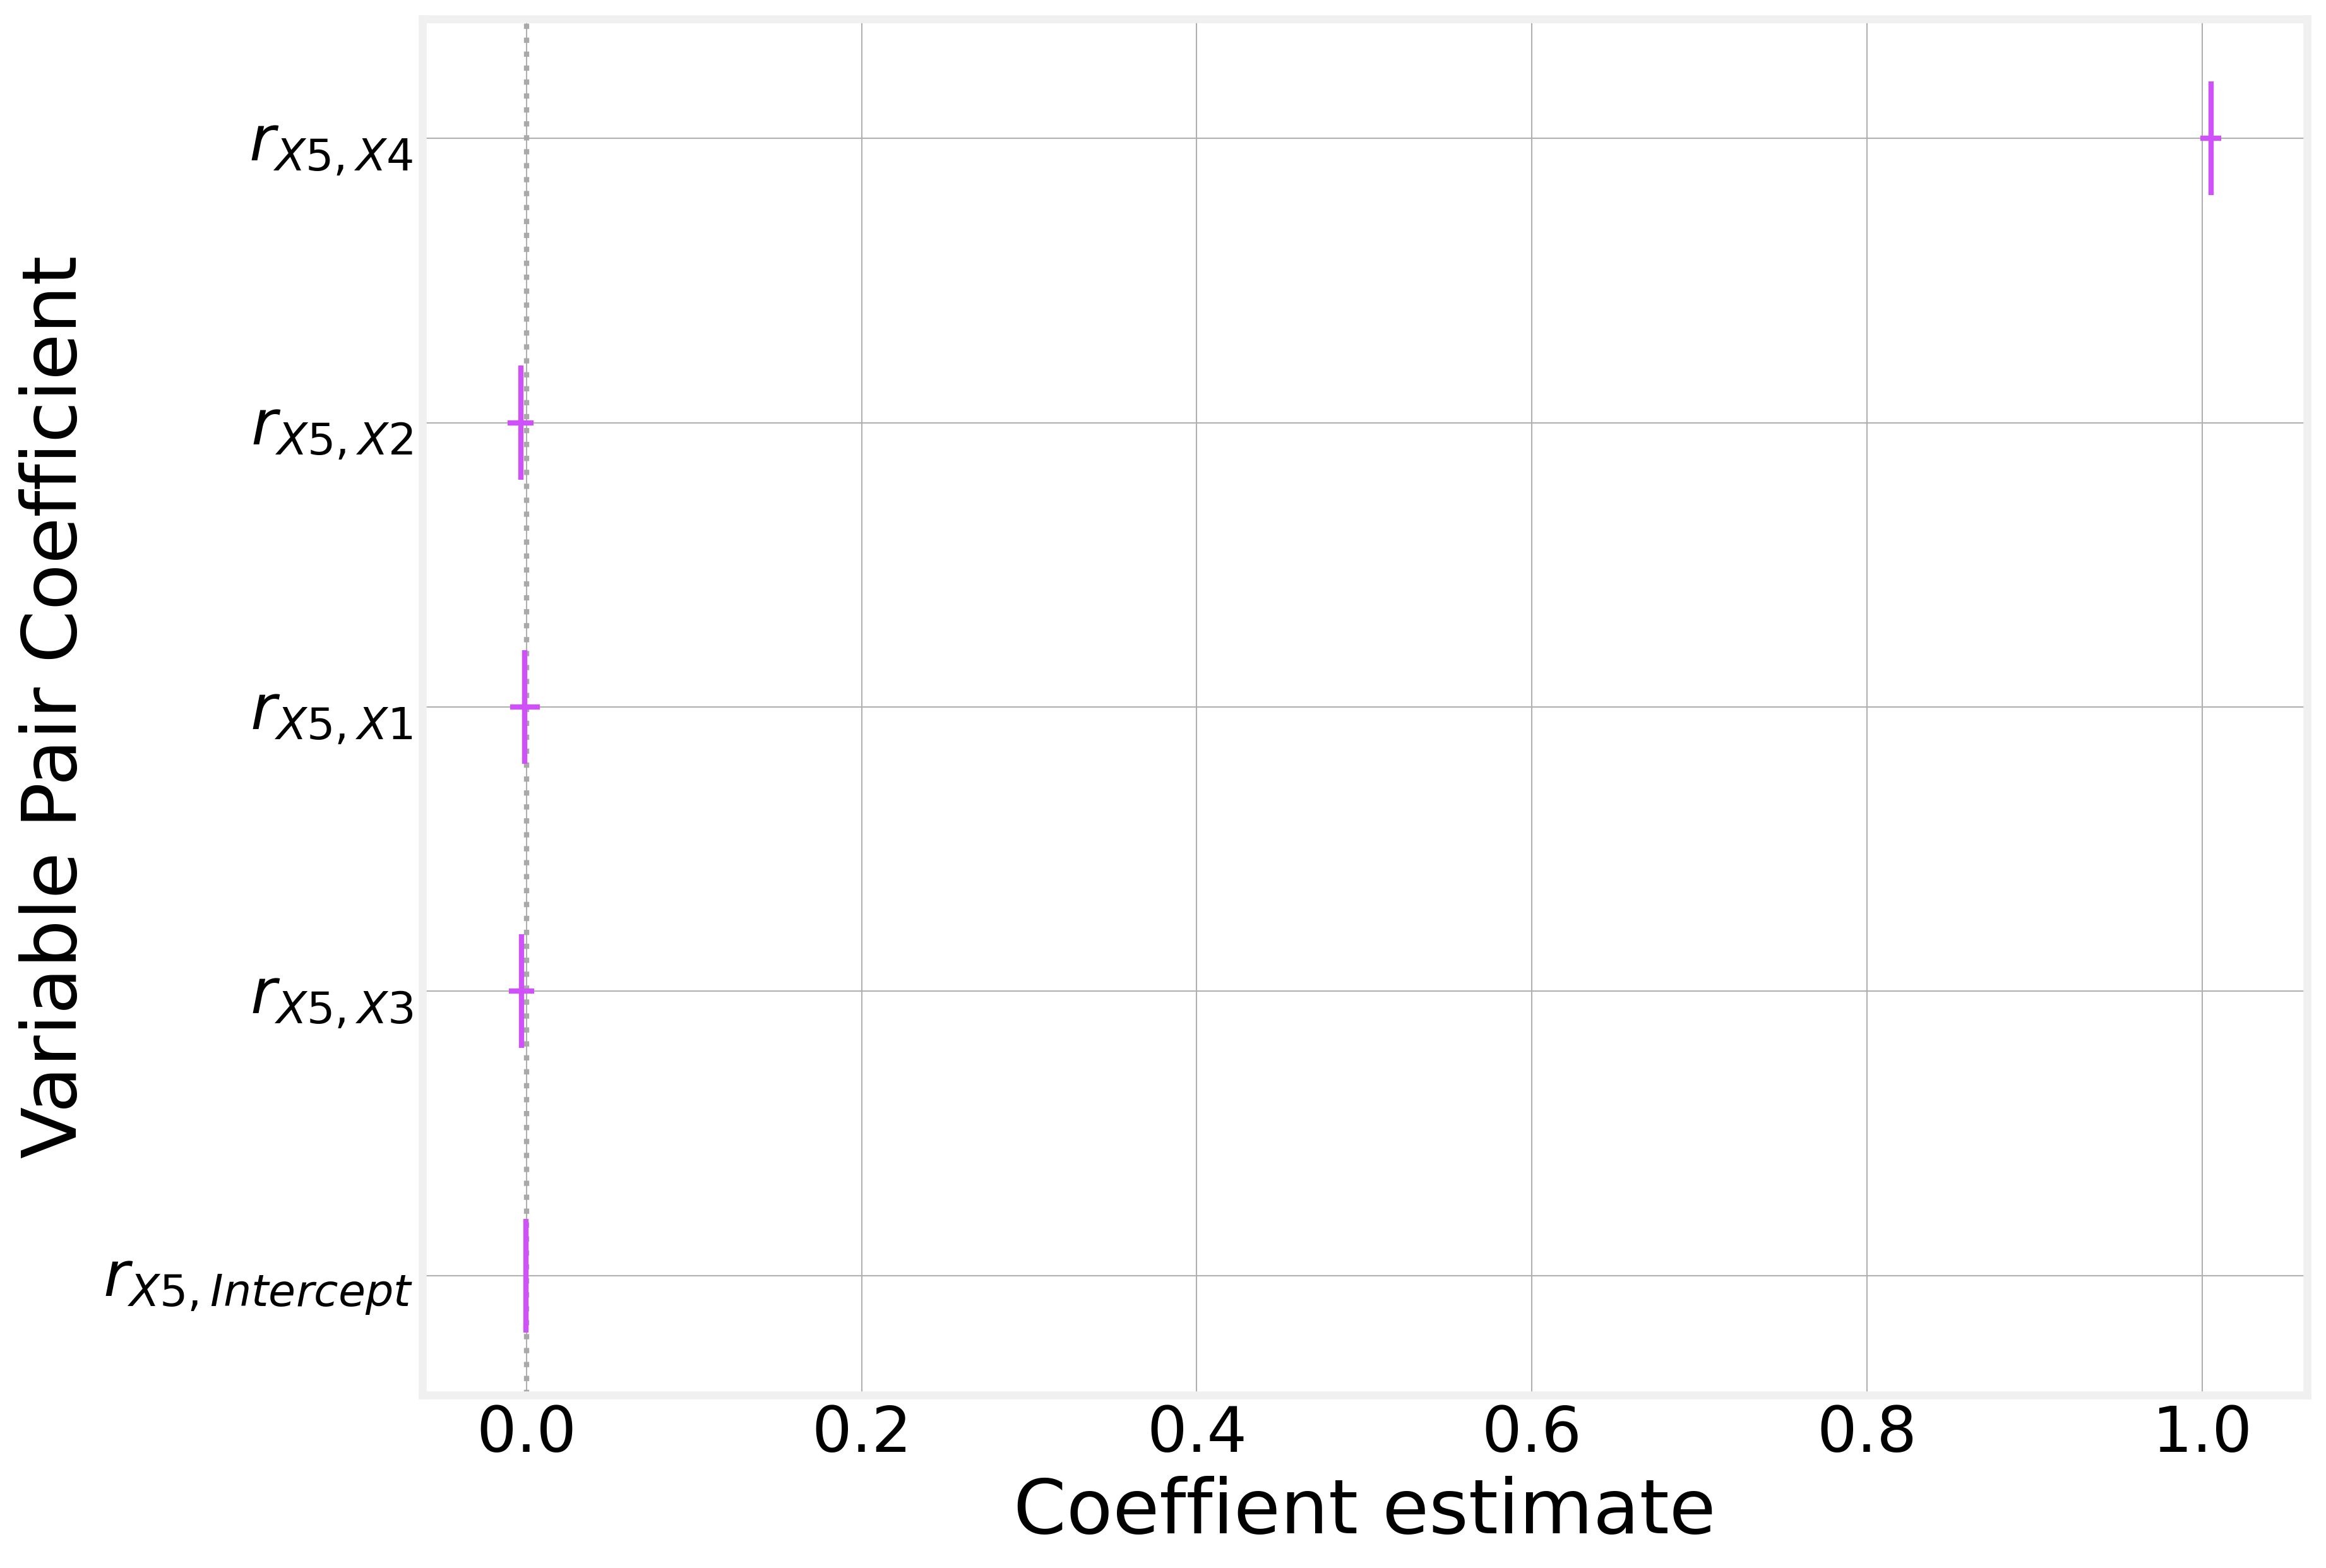

In [16]:
plot_coefficients(results)

Now let us consider a more 

In [17]:
fig29 = CausalModel()
fig29.load_model('dags/Primer.Fig.2.9.dot')

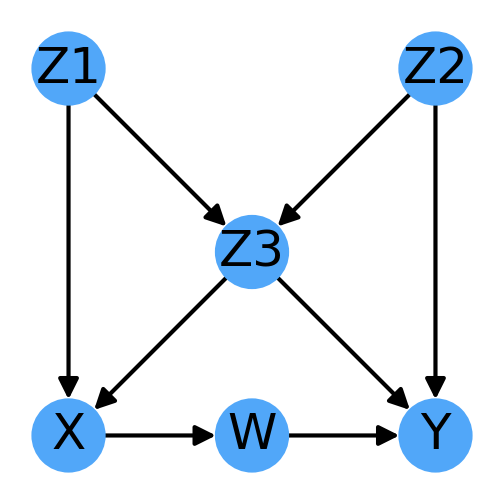

In [18]:
fig, ax = plt.subplots(1, figsize=(2.2, 2.2))
fig29.plot(ax=ax)

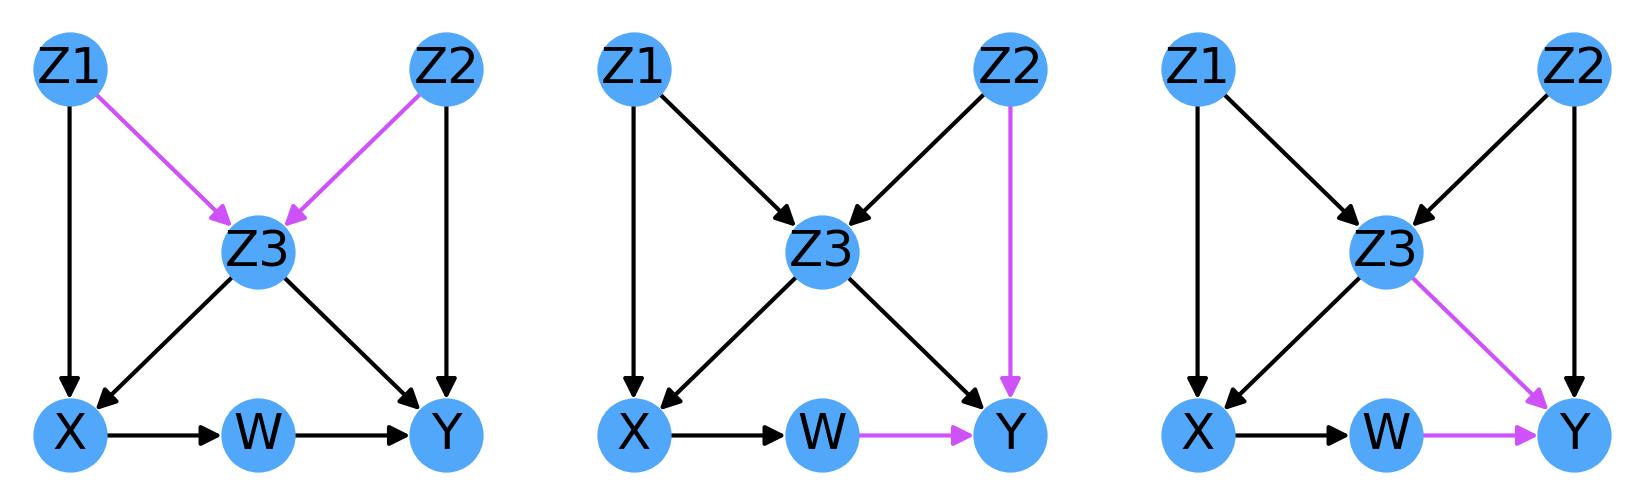

In [19]:
fig, ax_lst = plt.subplots(1, 3, figsize=(6, 2.2))
ax_lst = np.array(ax_lst).flatten()

structs = fig29.v_structures()

for i, path in enumerate(structs):
    fig29.plot_path(path, ax=ax_lst[i], edges=True, lw=1)

ax_lst[-1].axis('off')
fig.tight_layout()

In [20]:
fig29.equivalence_class()

[[<CausalModel.CausalModel at 0x2016cbd9850>, []]]

In [21]:
fig29.basis_set()

['W _||_ Z1, Z2, Z3 | X',
 'X _||_ Z2 | Z1, Z3',
 'Y _||_ X, Z1 | W, Z2, Z3',
 'Z1 _||_ Z2',
 'Z2 _||_ Z1']

In [22]:
formula = 'Y ~ 1 + X + Z1 + W + Z2 + Z3'

In [23]:
N = 100000
df = pd.DataFrame({'Z1': np.random.normal(0, 1, N), 'Z2': np.random.normal(0, 1, N),})
df['Z3'] = df['Z1'] + df['Z2'] + np.random.normal(0, .1, N)
df['X'] = df['Z1'] + df['Z3'] + np.random.normal(0, .1, N)
df['W'] = df['X'] + np.random.normal(0, .1, N)
df['Y'] = df['W'] + df['Z3'] + df['Z2'] + np.random.normal(0, .1, N)

In [24]:
results = smf.ols(formula, df).fit()

In [25]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.649e+07
Date:                Sat, 26 Apr 2025   Prob (F-statistic):               0.00
Time:                        14:03:51   Log-Likelihood:                 88644.
No. Observations:              100000   AIC:                        -1.773e+05
Df Residuals:                   99994   BIC:                        -1.772e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0006      0.000     -1.963      0.050      -0.001   -1.03e-06
X           3.179e-05      0.004      0.007      0.994      -0.009       0.009
Z1            -0.0018      0.004     -0.401      0.689      -0.011       0.007
W              1.0000      0.003    317.461      0.000       0.994       1.006
Z2             0.9990      0.003    314.081      0.000       0.993       1.005
Z3             1.0016      0.004    224.327      0.000       0.993       1.010
==============================================================================
Omnibus:                        0.921   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.631   Jarque-Bera (JB):                0.931
Skew:                          -0.004   Prob(JB):                        0.628
Kurtosis:                       2.988   Cond. No.                         68.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

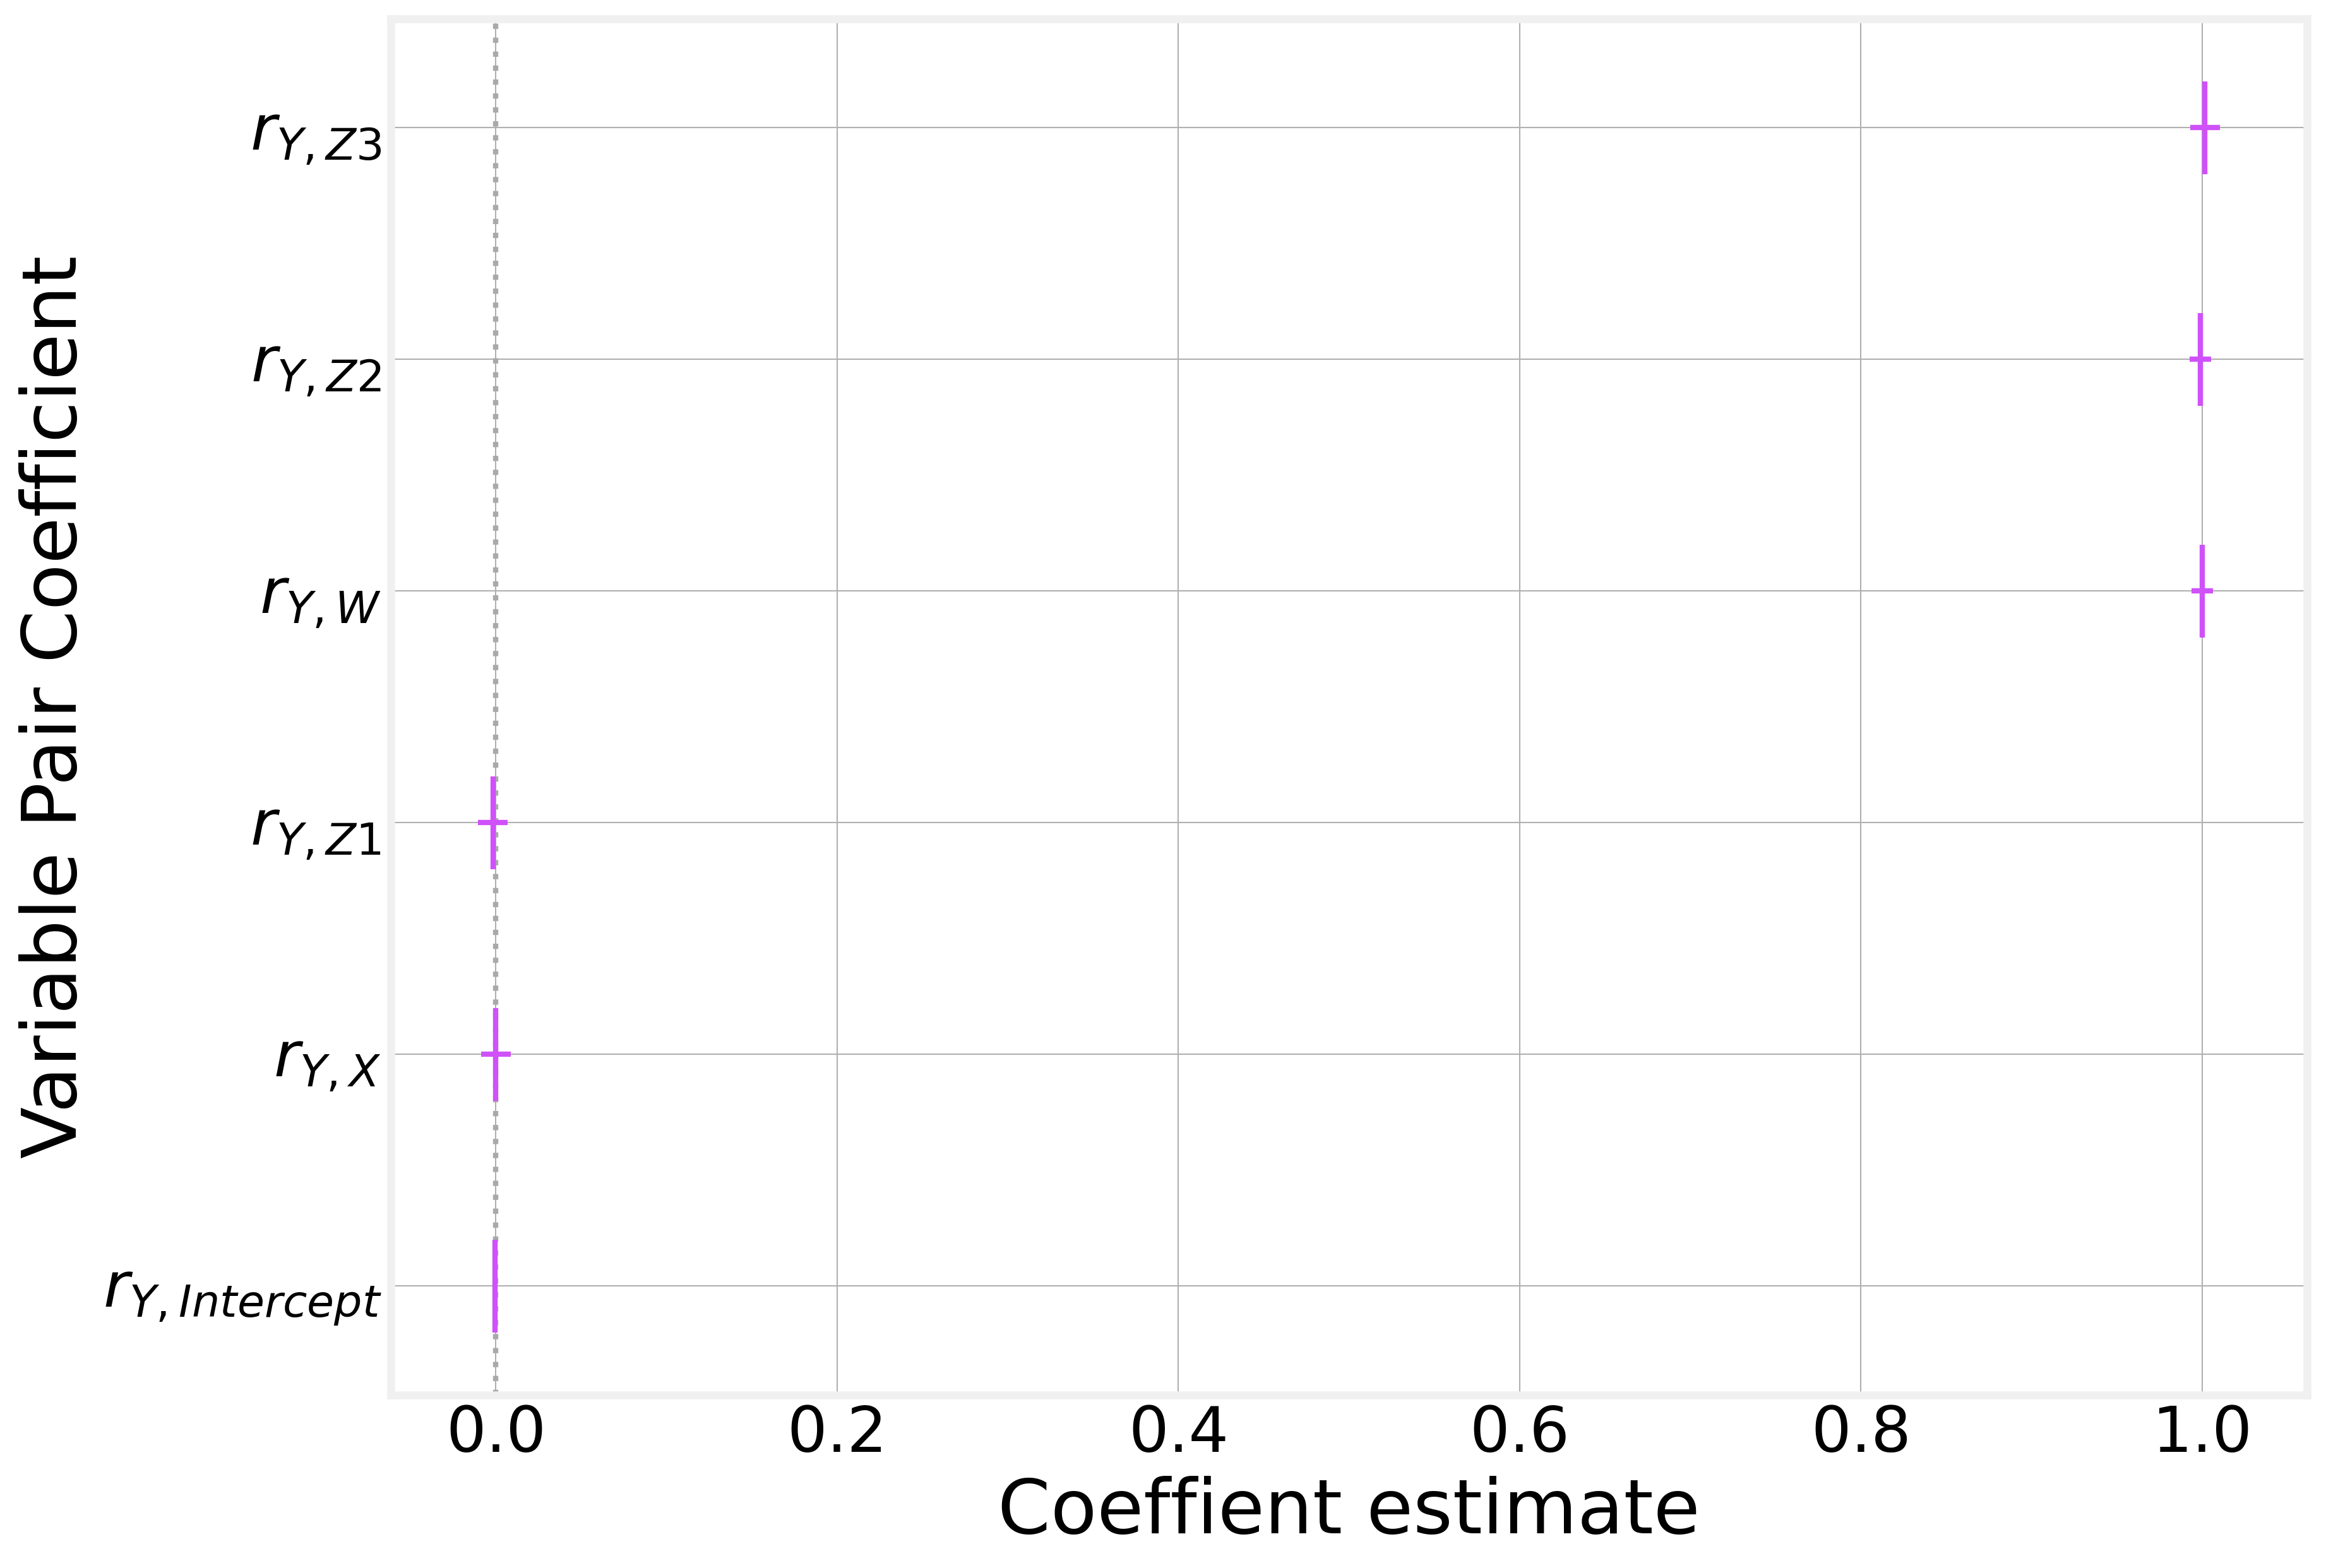

In [26]:
plot_coefficients(results)

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>